## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.corpus import stopwords
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from textblob import TextBlob
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from pprint import pprint

2022-10-19 17:21:34.969536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 17:21:34.999872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-19 17:21:35.000059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names
df.columns = [re.sub('^_','',col) for col in df.columns]
df.columns = [re.sub(r'^\bsource\b\.','',col) for col in df.columns]
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [6]:
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
#Assign nan in place of blanks in the complaints column
print(len(df[df['complaint_what_happened']=='']))
df['complaint_what_happened'].replace("",np.nan,inplace=True)
print(len(df[df['complaint_what_happened']=='']))

57241
0


In [8]:
#Remove all rows where complaints column is nan
print(df['complaint_what_happened'].isna().sum())
df.dropna(subset=['complaint_what_happened'],inplace = True)
print(df['complaint_what_happened'].isna().sum())

57241
0


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [9]:
df['complaint_what_happened'].head()

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
Name: complaint_what_happened, dtype: object

In [10]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]','',text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation),'',text)
    text = re.sub(r'\w*\d\w*','',text)
    return " ".join(text.split())

In [11]:
#Write your function to Lemmatize the texts
def lemmatizer(text):
    sent = []
    doc = nlp(text)
    for tok in doc:
        sent.append(tok.lemma_)
    return " ".join(sent)

In [12]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x : clean_text(x))
import en_core_web_sm
nlp = en_core_web_sm.load()
df_clean['lemmatized_complaint'] = df_clean.apply(lambda x: lemmatizer(x['complaint_what_happened']), axis = 1)

In [13]:
df_clean

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yrs I ve have ...


In [14]:
#Write your function to extract the POS tags 

def pos_tag(text):
    text_blob = TextBlob(text)
    return ' '.join([word for (word,tag) in text_blob.tags if tag == "NN"])



df_clean["complaint_POS_removed"] =  df_clean['lemmatized_complaint'].apply(pos_tag)

In [15]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean["complaint_POS_removed"]

1        morning name stop bank cardmember service ask ...
2        card agent upgrade date agent information orde...
10       card report application identity consent servi...
11       try book xxxx ticket offer ticket card informa...
14       son chase account fund bank account pay money ...
                               ...                        
78303    card customer decade solicitation credit card ...
78309    visa credit card provider claim purchase prote...
78310    pay risk provide consumer bank app chase year ...
78311    credit yrs credit card chase freedom xxxx prob...
78312    year account jp bank xxxx order line credit ac...
Name: complaint_POS_removed, Length: 21072, dtype: object

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




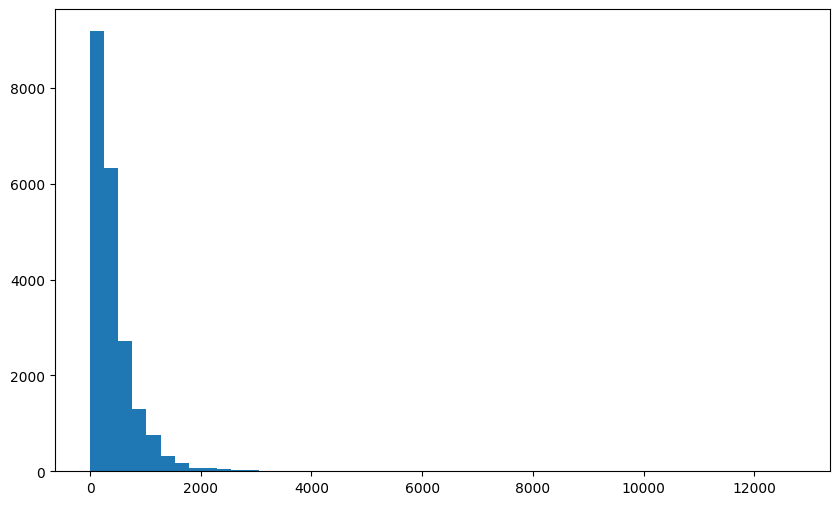

In [16]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(docs) for docs in df_clean.complaint_POS_removed]
plt.hist(doc_lens, bins = 50)
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

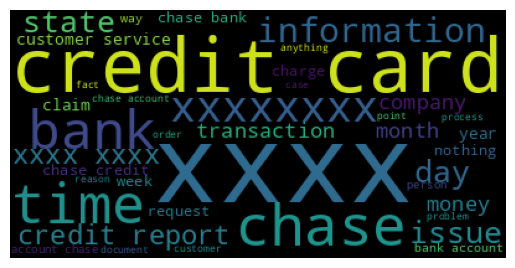

In [17]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stops = set(stopwords.words('english'))
wc = WordCloud(stopwords =stops , max_words=40).generate(' '.join(df_clean['complaint_POS_removed']))
fig = plt.figure(1)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [18]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [19]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_ngrams(corpus, n=None,ngram_range=(1,1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x : x[1], reverse=True)
    return words_freq[:n]
commons_words = get_top_ngrams(df_clean['Complaint_clean'], 30)

In [20]:
#Print the top 10 words in the unigram frequency
df_unigram = pd.DataFrame(commons_words, columns=['unigram','count'])
df_unigram.iloc[:10,:]

,unigram,count
0,account,47494
1,chase,46694
2,xxxx,36518
3,credit,34131
4,card,29276
5,bank,28409
6,payment,21164
7,time,16009
8,charge,14990
9,day,12958


In [21]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram_range=(2,2))
df_bigram = pd.DataFrame(top_30words,columns=['bigram','count'])
df_bigram

,bigram,count
0,credit card,12779
1,credit report,4007
2,xxxx xxxx,3926
3,customer service,3079
4,chase credit,2966
5,chase bank,2942
6,bank account,2777
7,chase account,2625
8,account chase,2596
9,account account,2416


In [22]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12779
1,credit report,4007
2,xxxx xxxx,3926
3,customer service,3079
4,chase credit,2966
5,chase bank,2942
6,bank account,2777
7,chase account,2625
8,account chase,2596
9,account account,2416


In [23]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'),n=30,ngram_range=(3,3))
df_trigram = pd.DataFrame(top_30words,columns=['trigram','count'])
df_trigram

,trigram,count
0,chase credit card,2063
1,credit card account,1026
2,credit card company,990
3,credit card chase,635
4,credit card credit,515
5,inquiry credit report,480
6,charge credit card,422
7,xxxx xxxx xxxx,410
8,account credit card,402
9,card credit card,389


In [24]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,2063
1,credit card account,1026
2,credit card company,990
3,credit card chase,635
4,credit card credit,515
5,inquiry credit report,480
6,charge credit card,422
7,xxxx xxxx xxxx,410
8,account credit card,402
9,card credit card,389


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [25]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [26]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yrs I ve have ...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [27]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [28]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

dtm = tfidf.fit_transform(df_clean['Complaint_clean'])
dtm

<21072x7258 sparse matrix of type '<class 'numpy.float64'>'
	with 642850 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [29]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [30]:
#Load your nmf_model with the n_components i.e 5
num_topics = list(np.arange(5,10,1))

#keep the random_state =40
nmf_model = NMF(n_components=5,random_state=40)

In [31]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

7258

In [32]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'Top 15 words for each of the topics #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

Top 15 words for each of the topics #0
['transfer', 'claim', 'checking', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']


Top 15 words for each of the topics #1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


Top 15 words for each of the topics #2
['mortgage', 'year', 'chase', 'account', 'credit', 'pay', 'date', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']


Top 15 words for each of the topics #3
['company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'chase', 'dispute', 'transaction', 'fee', 'card', 'charge']


Top 15 words for each of the topics #4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




In [33]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2])

In [34]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = topic_result.argmax(axis=1)

In [35]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [36]:
#Print the first 5 Complaint for each of the Topics
df_clean_top5_each=df_clean.groupby('Topic').head(5)
df_clean_top5_each.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [37]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:"Bank Account services",
              1:"Credit card or prepaid card",
              2:"Others",
              3:"Theft/Dispute Reporting",
              4:"Mortage/Loan"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [38]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told b...,I upgrade my xxxx xxxx card in and be tell by ...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,chase card was reported on however fraudulent ...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i c...,on while try to book a xxxx xxxx ticket I come...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,my grand son give I check for I deposit it int...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had cha...,I have have flawless credit for yrs I ve have ...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [39]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_what_happened','Topic']]

In [40]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card
10,chase card was reported on however fraudulent ...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i c...,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,Bank Account services
...,...,...
78303,after being a chase card customer for well ove...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,Theft/Dispute Reporting
78311,i have had flawless credit for yrs ive had cha...,Others


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [41]:
#Write your code to get the Vector count
count_vector = CountVectorizer()

#Write your code here to transform the word vector to tf-idf
X_train_count = count_vector.fit_transform(training_data['complaint_what_happened'])

In [42]:
tfidf_transform = TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf,training_data.Topic,test_size=0.2,random_state=42)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16857, 33599)
(4215, 33599)
(16857,)
(4215,)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [45]:
accuracy_f1_df = pd.DataFrame(columns = ['Model Name','Accuracy', 'F1 Score'])

### Logistic Regression

In [46]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train,y_train)
y_pred_lr = lr.predict(X_test)

In [47]:
print(classification_report(y_pred=y_pred_lr,y_true=y_test))

                             precision    recall  f1-score   support

      Bank Account services       0.91      0.95      0.93      1057
Credit card or prepaid card       0.91      0.95      0.93      1048
               Mortage/Loan       0.94      0.93      0.93       716
                     Others       0.95      0.85      0.90       439
    Theft/Dispute Reporting       0.92      0.89      0.90       955

                   accuracy                           0.92      4215
                  macro avg       0.93      0.91      0.92      4215
               weighted avg       0.92      0.92      0.92      4215



In [48]:
cf_lr = confusion_matrix(y_true=y_test,y_pred=y_pred_lr)
cf_lr

array([[1008,   21,    6,    3,   19],
       [  11,  993,    5,    5,   34],
       [  19,   22,  664,    4,    7],
       [  17,   17,   18,  372,   15],
       [  51,   33,   14,    6,  851]])

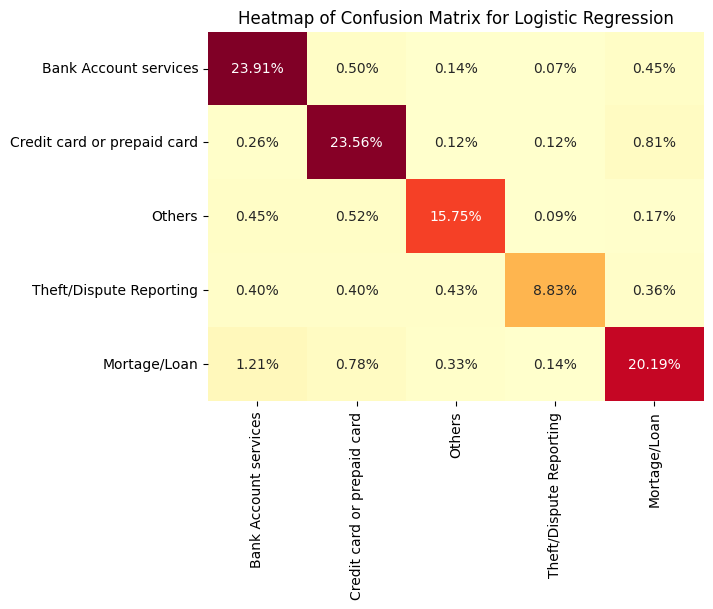

In [49]:
plt.title("Heatmap of Confusion Matrix for Logistic Regression")
sns.heatmap(cf_lr/np.sum(cf_lr),annot=True,cbar=None,cmap='YlOrRd', fmt='.2%',
           xticklabels=['Bank Account services','Credit card or prepaid card','Others','Theft/Dispute Reporting','Mortage/Loan'],
           yticklabels=['Bank Account services','Credit card or prepaid card','Others','Theft/Dispute Reporting','Mortage/Loan'])
plt.show()

In [50]:
lr_row = {'Model Name':'Linear Regression','Accuracy':round(accuracy_score(y_true=y_test,y_pred=y_pred_lr),2),
         'F1 Score': round(f1_score(y_pred=y_pred_lr,y_true=y_test,average='weighted'),2)}

In [51]:
accuracy_f1_df =  accuracy_f1_df.append(lr_row, ignore_index=True)
accuracy_f1_df.head()

,Model Name,Accuracy,F1 Score
0,Linear Regression,0.92,0.92


### Decision Tree

In [52]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred_dt = dt.predict(X_test)

In [53]:
#using hyperparameters
dt_param = {
    'criterion':['gini','entropy'],
    'max_depth':[5,10,15,20,25,30],
    'min_samples_leaf':[1,5,10,15,20,25],
}
grid_dt = GridSearchCV(estimator=dt,
                      param_grid=dt_param,
                      verbose=1,
                      scoring='f1_weighted',
                      n_jobs=-1,
                      cv=5)
grid_dt.fit(X_train,y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 15}


In [54]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=30, min_samples_leaf=15,)
dt.fit(X_train,y_train)
y_pred_dt_2 = dt.predict(X_test)

In [55]:
print(classification_report(y_pred=y_pred_dt_2,y_true=y_test))

                             precision    recall  f1-score   support

      Bank Account services       0.81      0.82      0.81      1057
Credit card or prepaid card       0.83      0.82      0.83      1048
               Mortage/Loan       0.81      0.84      0.82       716
                     Others       0.78      0.77      0.78       439
    Theft/Dispute Reporting       0.77      0.74      0.75       955

                   accuracy                           0.80      4215
                  macro avg       0.80      0.80      0.80      4215
               weighted avg       0.80      0.80      0.80      4215



In [56]:
cf_dt = confusion_matrix(y_true=y_test,y_pred=y_pred_dt)
cf_dt

array([[845,  50,  40,  33,  89],
       [ 51, 877,  37,  14,  69],
       [ 47,  18, 578,  35,  38],
       [ 10,  41,  34, 324,  30],
       [117,  87,  41,  27, 683]])

In [57]:
cf_dt2 = confusion_matrix(y_true=y_test,y_pred=y_pred_dt_2)
cf_dt2

array([[870,  40,  39,  23,  85],
       [ 45, 864,  37,  21,  81],
       [ 42,  19, 599,  30,  26],
       [ 18,  34,  30, 338,  19],
       [104,  87,  39,  21, 704]])

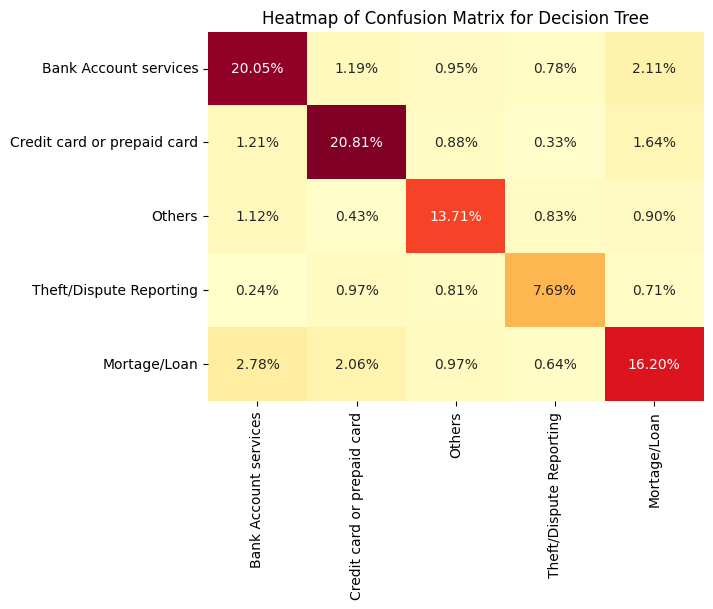

In [58]:
plt.title("Heatmap of Confusion Matrix for Decision Tree")
sns.heatmap(cf_dt/np.sum(cf_dt),annot=True,cbar=None,cmap='YlOrRd', fmt='.2%',
           xticklabels=['Bank Account services','Credit card or prepaid card','Others','Theft/Dispute Reporting','Mortage/Loan'],
           yticklabels=['Bank Account services','Credit card or prepaid card','Others','Theft/Dispute Reporting','Mortage/Loan'])
plt.show()

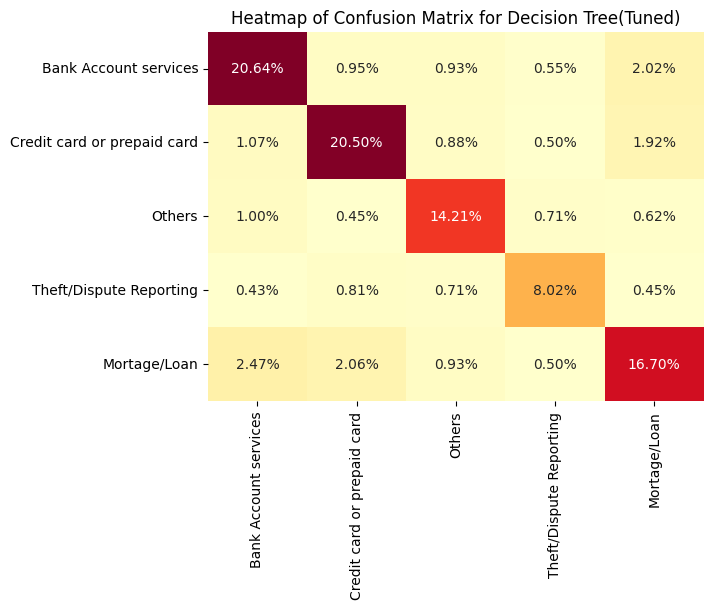

In [59]:
plt.title("Heatmap of Confusion Matrix for Decision Tree(Tuned)")
sns.heatmap(cf_dt2/np.sum(cf_dt2),annot=True,cbar=None,cmap='YlOrRd', fmt='.2%',
           xticklabels=['Bank Account services','Credit card or prepaid card','Others','Theft/Dispute Reporting','Mortage/Loan'],
           yticklabels=['Bank Account services','Credit card or prepaid card','Others','Theft/Dispute Reporting','Mortage/Loan'])
plt.show()

In [60]:
dt_row = {'Model Name':'Decision Tree','Accuracy':round(accuracy_score(y_true=y_test,y_pred=y_pred_dt),2),
         'F1 Score': round(f1_score(y_pred=y_pred_dt,y_true=y_test,average='weighted'),2)}
dt_row_tuned = {'Model Name':'Decision Tree(Tuned)','Accuracy':round(accuracy_score(y_true=y_test,y_pred=y_pred_dt_2),2),
         'F1 Score': round(f1_score(y_pred=y_pred_dt_2,y_true=y_test,average='weighted'),2)}

In [61]:
accuracy_f1_df =  accuracy_f1_df.append(dt_row, ignore_index=True)
accuracy_f1_df =  accuracy_f1_df.append(dt_row_tuned, ignore_index=True)
accuracy_f1_df.head(10)

,Model Name,Accuracy,F1 Score
0,Linear Regression,0.92,0.92
1,Decision Tree,0.78,0.78
2,Decision Tree(Tuned),0.80,0.80


### Random Forest Classifier

In [62]:
rf = RandomForestClassifier(max_depth=10)
rf.fit(X_train,y_train)
pred_rf = rf.predict(X_test)

In [63]:
rf_param = {
    'n_estimators':[2,4,6,8,10,12,14,16,20],
    'max_features':['auto','sqrt','log2'],
    'max_depth':[4,5,6,7,8,10],
    'criterion':['gini','entropy']
}
grif_rf = GridSearchCV(estimator=rf,
                      param_grid=rf_param,
                      cv=5,n_jobs=-1,verbose=1)
grif_rf.fit(X_train,y_train)
print(grif_rf.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/abhinavkrdubey/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this para

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 20}


In [64]:
rf = RandomForestClassifier(criterion='gini',max_depth=10,max_features='sqrt',n_estimators=20)
rf.fit(X_train,y_train)
pred_rf_2 = rf.predict(X_test)

In [65]:
print(classification_report(y_pred=pred_rf,y_true=y_test))

                             precision    recall  f1-score   support

      Bank Account services       0.71      0.87      0.78      1057
Credit card or prepaid card       0.61      0.86      0.72      1048
               Mortage/Loan       0.84      0.66      0.74       716
                     Others       1.00      0.03      0.05       439
    Theft/Dispute Reporting       0.79      0.71      0.75       955

                   accuracy                           0.71      4215
                  macro avg       0.79      0.63      0.61      4215
               weighted avg       0.76      0.71      0.67      4215



In [66]:
rf_cm = confusion_matrix(y_true=y_test,y_pred=pred_rf)
rf_cm

array([[921, 105,   7,   0,  24],
       [ 67, 904,   6,   0,  71],
       [ 77, 149, 474,   0,  16],
       [107, 184,  73,  11,  64],
       [134, 138,   6,   0, 677]])

In [67]:
print(classification_report(y_pred=pred_rf_2,y_true=y_test))

                             precision    recall  f1-score   support

      Bank Account services       0.63      0.85      0.72      1057
Credit card or prepaid card       0.61      0.81      0.69      1048
               Mortage/Loan       0.81      0.62      0.70       716
                     Others       0.92      0.05      0.10       439
    Theft/Dispute Reporting       0.73      0.61      0.67       955

                   accuracy                           0.66      4215
                  macro avg       0.74      0.59      0.58      4215
               weighted avg       0.71      0.66      0.63      4215



In [68]:
rf_cm2 = confusion_matrix(y_true=y_test,y_pred=pred_rf_2)
rf_cm2

array([[898, 116,  12,   0,  31],
       [ 82, 852,  12,   0, 102],
       [132, 109, 442,   2,  31],
       [134, 155,  73,  23,  54],
       [189, 173,   7,   0, 586]])

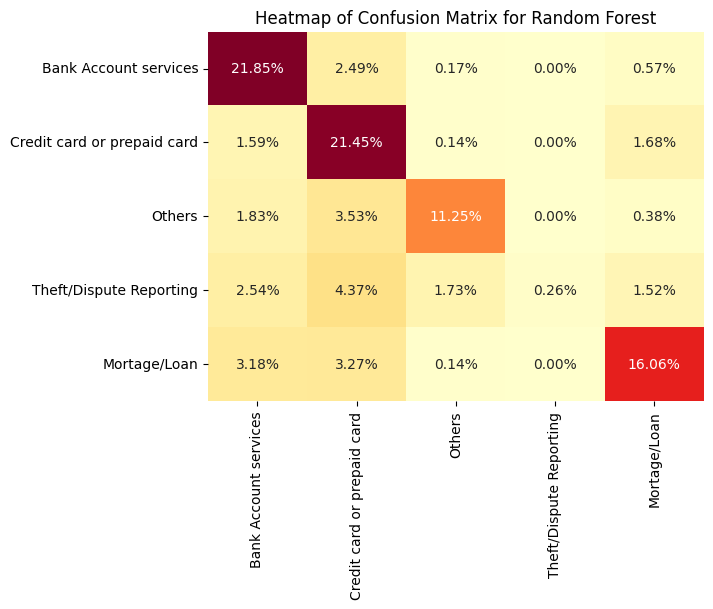

In [69]:
plt.title("Heatmap of Confusion Matrix for Random Forest")
sns.heatmap(rf_cm/np.sum(rf_cm),annot=True,cbar=None,cmap='YlOrRd', fmt='.2%',
           xticklabels=['Bank Account services','Credit card or prepaid card','Others','Theft/Dispute Reporting','Mortage/Loan'],
           yticklabels=['Bank Account services','Credit card or prepaid card','Others','Theft/Dispute Reporting','Mortage/Loan'])
plt.show()

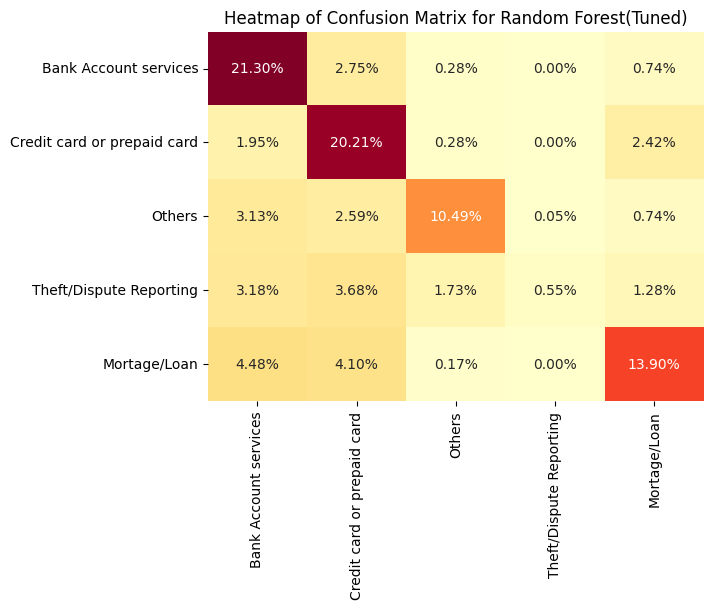

In [70]:
plt.title("Heatmap of Confusion Matrix for Random Forest(Tuned)")
sns.heatmap(rf_cm2/np.sum(rf_cm2),annot=True,cbar=None,cmap='YlOrRd', fmt='.2%',
           xticklabels=['Bank Account services','Credit card or prepaid card','Others','Theft/Dispute Reporting','Mortage/Loan'],
           yticklabels=['Bank Account services','Credit card or prepaid card','Others','Theft/Dispute Reporting','Mortage/Loan'])
plt.show()

In [71]:
rf_row = {'Model Name':'Random Forest','Accuracy':round(accuracy_score(y_true=y_test,y_pred=pred_rf),2),
         'F1 Score': round(f1_score(y_pred=pred_rf,y_true=y_test,average='weighted'),2)}
rf_row_tuned = {'Model Name':'Random Forest(Tuned)','Accuracy':round(accuracy_score(y_true=y_test,y_pred=pred_rf_2),2),
         'F1 Score': round(f1_score(y_pred=pred_rf_2,y_true=y_test,average='weighted'),2)}

In [72]:
accuracy_f1_df =  accuracy_f1_df.append(rf_row, ignore_index=True)
accuracy_f1_df =  accuracy_f1_df.append(rf_row_tuned, ignore_index=True)

In [73]:
accuracy_f1_df

,Model Name,Accuracy,F1 Score
0,Linear Regression,0.92,0.92
1,Decision Tree,0.78,0.78
2,Decision Tree(Tuned),0.80,0.80
3,Random Forest,0.71,0.67
4,Random Forest(Tuned),0.66,0.63


## Predictions: Model Inference

#### We choose Logistic Regression since it gives us the accuracy and f1 score of 0.92 i.e., 92%. So it is ideal for making predictions

In [74]:
complaint = pd.DataFrame({'complaints': ["Can you please let me know the process of opening a new account",
                                        "I want to know my CIBIL Score", "The amount debited from my card is more than what should have been debited"]})

In [75]:
complaint

,complaints
0,Can you please let me know the process of open...
1,I want to know my CIBIL Score
2,The amount debited from my card is more than w...


In [76]:
def lr_pred(text):
    X_new = count_vector.transform(text)
    X_new_tfidf = tfidf_transform.transform(X_new)
    predicted = lr.predict(X_new_tfidf)
    return predicted[0]

In [77]:
complaint['Tag'] = complaint['complaints'].apply(lambda x: lr_pred([x]))
complaint

,complaints,Tag
0,Can you please let me know the process of open...,Bank Account services
1,I want to know my CIBIL Score,Credit card or prepaid card
2,The amount debited from my card is more than w...,Credit card or prepaid card
